# MolDrug without receptor

One of the strengths of MolDrug is the ability to optimize on the chemical space based on docking results. However it could also be used to optimize some QSAR function when the information of the receptor is not available. Some previous of this application where show [here](https://moldrug.readthedocs.io/en/latest/notebooks/how_to.html#Create-your-own-cost-function).

## Imports and creating working directory

In [21]:
from pyexpat import model
from moldrug import utils
from rdkit import Chem
from rdkit.Chem import AllChem, Lipinski, Draw
import multiprocessing as mp
import shutil, os, gzip, requests, tempfile

tmp_path = tempfile.TemporaryDirectory()
wd = tmp_path.name
# or
# os.makedirs('tutorial_mwr', exist_ok=True)
# wd = os.path.abspath('tutorial_mwr')


## Getting the CReM data base

In [22]:
url = "http://www.qsar4u.com/files/cremdb/replacements02_sc2.db.gz"
r = requests.get(url, allow_redirects=True)
crem_dbgz_path = os.path.join(wd,'crem.db.gz')
crem_db_path = os.path.join(wd,'crem.db')
open(crem_dbgz_path, 'wb').write(r.content)
with gzip.open(crem_dbgz_path, 'rb') as f_in:
    with open(crem_db_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

## Define the function
Let's assume that our QSAR model give us that the best molecules are those ones that have more hydrogen bonds acceptor and donors. Because MolDrug minimize we must use the negative of this number.

In [23]:
def QSAR_model_cost(Individual:utils.Individual) -> utils.Individual:
    """Simple cost function

    Parameters
    ----------
    Individual : utils.Individual
        An initialize Individual

    Returns
    -------
    utils.Individual
        The individual with cost sum of HBA and HBD with negative sign
    """
    NumHAcceptors  = Lipinski.NumHAcceptors(Individual.mol)
    NumHDonors = Lipinski.NumHDonors(Individual.mol)
    model = NumHAcceptors + NumHDonors
    Individual.cost = -model
    return Individual


## Set MolDrug run

The next code is a duplication for the implementation of `QSAR_model_cost` fitness function.
Is written in this way due to some possible problems that might arise because the execution of multiprocessing inside `GA` on an interactive Python like IPython-Notebook.

This will create an importable function in your working directory. In case you execute this code in a python script rather that in a Notebook, consider to put the execution of the class after the section `if __name__ == '__main__:'`


In [24]:

function_string = """
from rdkit.Chem import  Lipinski
def QSAR_model_cost(Individual):
    NumHAcceptors  = Lipinski.NumHAcceptors(Individual.mol)
    NumHDonors = Lipinski.NumHDonors(Individual.mol)
    model = NumHAcceptors + NumHDonors
    Individual.cost = -model
    return Individual
"""
with open('my_cost.py', 'w') as f:
    f.write(function_string)
from my_cost import QSAR_model_cost

In [25]:
ga = utils.GA(
    Chem.MolFromSmiles('CCCC'),
    crem_db_path = os.path.join(tmp_path.name, 'crem.db'),
    maxiter = 10,
    popsize = 50,
    costfunc=QSAR_model_cost,
    mutate_crem_kwargs={
        'ncores': mp.cpu_count()
    },
    costfunc_kwargs={}
    )
ga(12)




Creating the first population with 50 members:


100%|██████████| 50/50 [00:01<00:00, 43.08it/s]

Initial Population: Best Individual: Individual(idx = 40, smiles = CN(C)N(O)N=O, cost = -5)
Accepted rate: 50 / 50



Evaluating generation 1 / 10:


100%|██████████| 48/48 [00:01<00:00, 34.57it/s]

Generation 1: Best Individual: Individual(idx = 63, smiles = O=P(O)(O)CCP(=O)(O)O, cost = -6).
Accepted rate: 28 / 48



Evaluating generation 2 / 10:


100%|██████████| 45/45 [00:01<00:00, 34.59it/s]

Generation 2: Best Individual: Individual(idx = 63, smiles = O=P(O)(O)CCP(=O)(O)O, cost = -6).
Accepted rate: 18 / 45



Evaluating generation 3 / 10:


100%|██████████| 48/48 [00:01<00:00, 41.87it/s]

Generation 3: Best Individual: Individual(idx = 175, smiles = N=C(N)NN=CC(=O)O, cost = -7).
Accepted rate: 19 / 48



Note: The mutation on Individual(idx = 145, smiles = Nc1nc2ccccc2[n+]([O-])n1, cost = -5) did not work, it will be returned the same individual
Evaluating generation 4 / 10:


100%|██████████| 48/48 [00:01<00:00, 37.42it/s]

Generation 4: Best Individual: Individual(idx = 200, smiles = COc1nc(N)nc(OC)c1N=O, cost = -8).
Accepted rate: 12 / 48



Note: The mutation on Individual(idx = 145, smiles = Nc1nc2ccccc2[n+]([O-])n1, cost = -5) did not work, it will be returned the same individual
Note: The mutation on Individual(idx = 145, smiles = Nc1nc2ccccc2[n+]([O-])n1, cost = -5) did not work, it will be returned the same individual
Evaluating generation 5 / 10:


100%|██████████| 46/46 [00:01<00:00, 31.64it/s]

Generation 5: Best Individual: Individual(idx = 275, smiles = NC(C(=O)O)C(O)C(O)C(O)CO, cost = -12).
Accepted rate: 12 / 46



Note: The mutation on Individual(idx = 145, smiles = Nc1nc2ccccc2[n+]([O-])n1, cost = -5) did not work, it will be returned the same individual
Evaluating generation 6 / 10:


100%|██████████| 48/48 [00:01<00:00, 33.12it/s]


Generation 6: Best Individual: Individual(idx = 275, smiles = NC(C(=O)O)C(O)C(O)C(O)CO, cost = -12).
Accepted rate: 14 / 48

Evaluating generation 7 / 10:


100%|██████████| 49/49 [00:01<00:00, 31.17it/s]

Generation 7: Best Individual: Individual(idx = 275, smiles = NC(C(=O)O)C(O)C(O)C(O)CO, cost = -12).
Accepted rate: 7 / 49



Evaluating generation 8 / 10:


100%|██████████| 49/49 [00:01<00:00, 29.06it/s]

Generation 8: Best Individual: Individual(idx = 275, smiles = NC(C(=O)O)C(O)C(O)C(O)CO, cost = -12).
Accepted rate: 13 / 49



Evaluating generation 9 / 10:


100%|██████████| 50/50 [00:01<00:00, 30.44it/s]

Generation 9: Best Individual: Individual(idx = 275, smiles = NC(C(=O)O)C(O)C(O)C(O)CO, cost = -12).
Accepted rate: 13 / 50



Evaluating generation 10 / 10:


100%|██████████| 49/49 [00:01<00:00, 26.09it/s]

Generation 10: Best Individual: Individual(idx = 275, smiles = NC(C(=O)O)C(O)C(O)C(O)CO, cost = -12).
Accepted rate: 13 / 49


=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

The simulation finished successfully after 10 generations with a population of 50 individuals. A total number of 529 Individuals were seen during the simulation.
Initial Individual: Individual(idx = 0, smiles = CCCC, cost = 0)
Final Individual: Individual(idx = 275, smiles = NC(C(=O)O)C(O)C(O)C(O)CO, cost = -12)
The cost function dropped in 12 units.

=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

Total time (10 generations): 480.95 (s).
Finished at Mon Sep  4 19:54:16 2023.



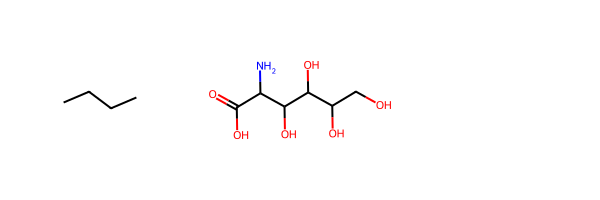

In [26]:
Draw.MolsToGridImage([ga.InitIndividual.mol, ga.pop[0].mol])

As you can see, this simulation is really good: On every single carbon atom it is bound, at least, one HBD and/or HBA! (Your results might differ)

[Text(0.5, 1.0, 'best_cost')]

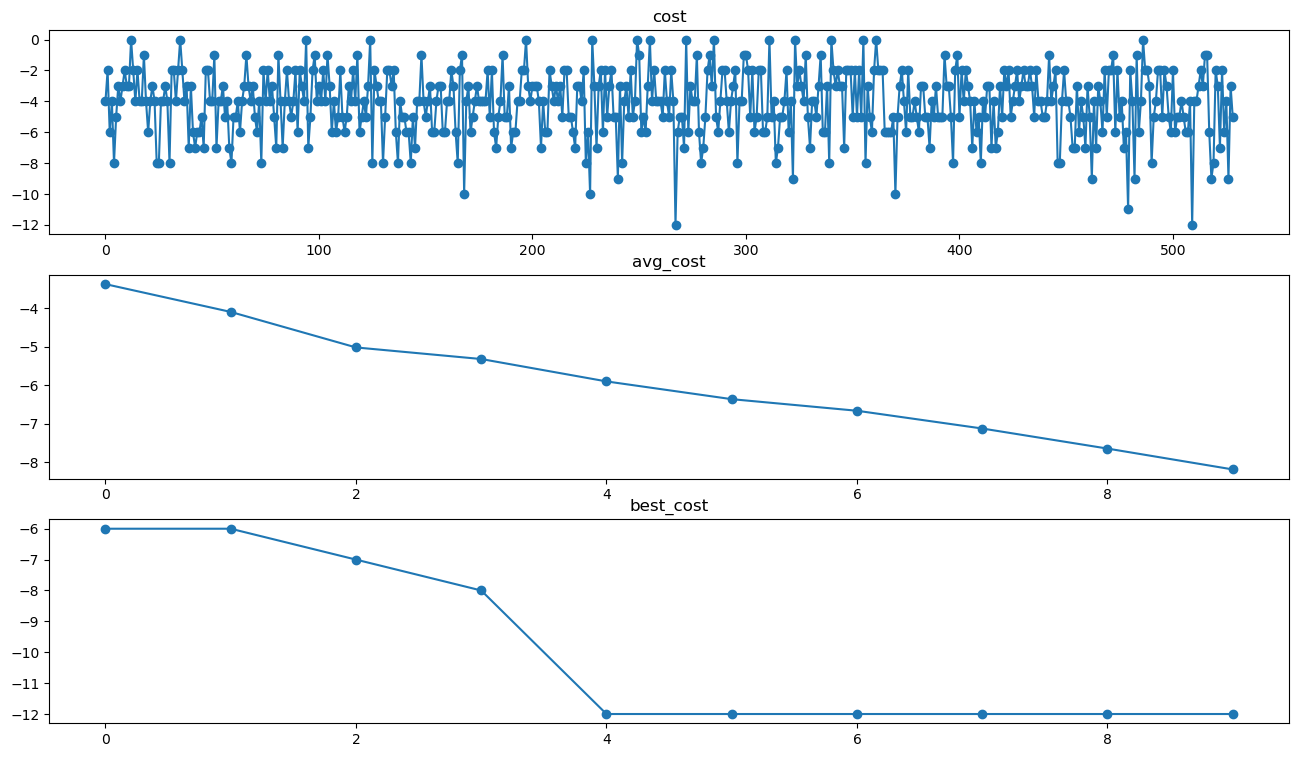

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=3,  figsize = (16,9))
ax[0].plot([individual.cost for individual in ga.SawIndividuals], '-o')
ax[0].set(title = 'cost')
ax[1].plot([cost for cost in ga.avg_cost], '-o')
ax[1].set(title = 'avg_cost')
ax[2].plot([cost for cost in ga.best_cost], '-o')
ax[2].set(title = 'best_cost')